# Owl
## A Retirement Planning Laboratory

This package is a retirement modeling framework for exploring the sensitivity of retirement financial decisions. Strictly speaking, it is not a planning tool, but more an environment for exploring *what if* scenarios. It provides different realizations of a financial strategy. One can certainly have a savings plan, but due to the volatility of financial investments, it is impossible to have a certain asset earnings plan. This does not mean one cannot make decisions. These decisions need to be guided with an understanding of the sensitivity of the parameters.This is exactly where this tool fits it. Given your savings and spending desires, it can generate different future realizations of your strategy under different market assumptions, helping to better understand your financial situation.

The algorithm in Owl is using the open-source HiGHS linear programming solver.
The complete formulation and detailed description of the underlying
mathematical model can be found
[here](https://raw.githubusercontent.com/mdlacasse/Owl/main/docs/owl.pdf).

Copyright &copy; 2024 - Martin-D. Lacasse

Disclaimers: *I am not a financial planner. You make your own decisions. This program comes with no guarantee. Use at your own risk.*

### <span style="color: blue"> README FIRST </span>
<span style="color:black;background:yellow;font-weight:bold">
Don't make changes directly to this file. Keep it as a working example. Therefore, it is recommended that you build your own case by making a copy of the template files provided where you will be able to enter your own numbers and explore your own assumptions.
</span>

# Tutorial 2 - Using the case of Jack and Jill
This tutorial shows how to use advanced capabilities of Owl such as Monte Carlo simulations and running simulations over a historical range. We use the same case as the one in Tutorial 1. 

### Just some Python module bookkeeping
This command needs to be at the beginning of every Owl notebook.

In [1]:
import owlplanner as owl

### Creating the plan (see Tutorial 1 for details)
We first create a plan as we did in the *Tutorial 1*. We removed the comments for reducing the clutter.

In [2]:
plan = owl.Plan(['Jack', 'Jill'], [1962, 1965], [89, 92], 'jack+jill-spending-MC', verbose=True)

Using stdout and stderr as stream loggers.
Setting logstreams to None.
Preparing scenario of 34 years for 2 individuals.
          Jack: life horizon from 2024 -> 2051.
          Jill: life horizon from 2024 -> 2057.
Setting 1st-year starting date to 2024-12-30.
Problem has 9 distinct time series forming 1026 decision variables.


In [3]:
plan.setAccountBalances(
    taxable=[90.5, 60],
    taxDeferred=[600.2, 150],
    taxFree=[50 + 20.6, 40.8],
)

Taxable balances: $90,500 $60,000
Tax-deferred balances: $600,200 $150,000
Tax-free balances: $70,600 $40,800
Sum of all savings accounts: $1,012,100
Post-tax total wealth of approximately $787,040


In [4]:
plan.readContributions('jack+jill.xlsx')

Reading wages, contributions, conversions, and big-ticket items over time...
	for Jack...
	for Jill...
Successfully read time horizons from file "jack+jill.xlsx".


Asset allocation interpolation method set to s-curve.
Jack : Setting gliding allocation ratios (%) to individual
	 [60, 40, 0, 0] -> [70, 30, 0, 0]
Jill : Setting gliding allocation ratios (%) to individual
	 [60, 40, 0, 0] -> [70, 30, 0, 0]
Interpolating assets allocation ratios using s-curve method.


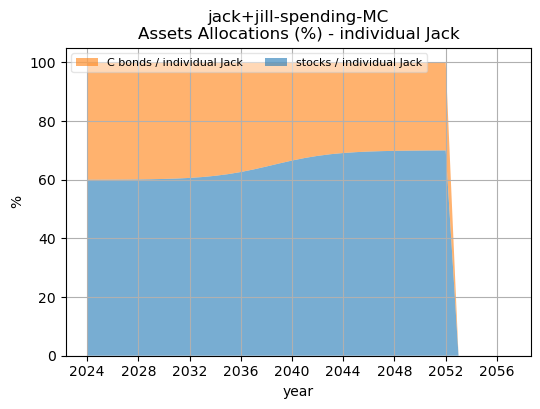

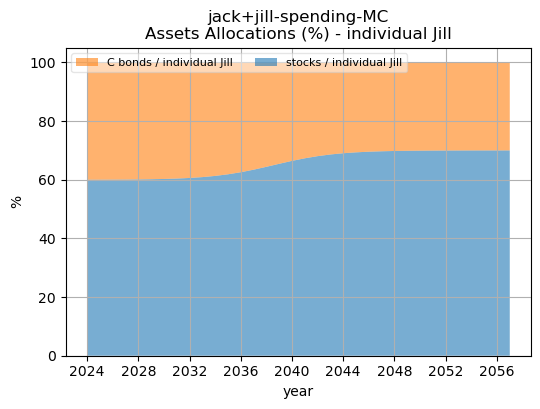

In [5]:
plan.setInterpolationMethod('s-curve')
plan.setAllocationRatios(
    'individual',
    generic=[[[60, 40, 0, 0], [70, 30, 0, 0]], [[60, 40, 0, 0], [70, 30, 0, 0]]],
)
plan.showAllocations()

In [6]:
plan.setPension([0, 10], [65, 65])
plan.setSocialSecurity([28, 25], [70, 70])

Setting pension of ['$0', '$10,000'] at age(s) [65, 65]
Setting social security benefits of ['$28,000', '$25,000'] at age(s) [70, 70]


Setting smile spending profile.
Securing 60% of spending amount for surviving spouse.


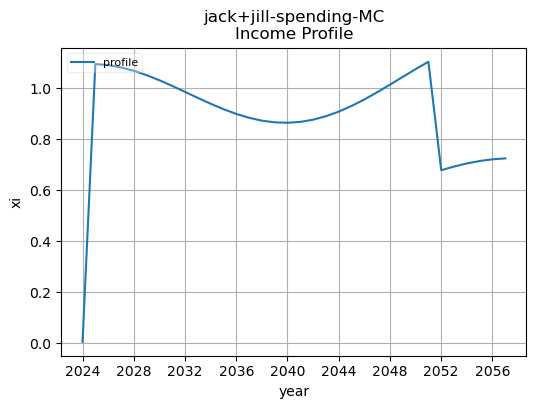

In [7]:
plan.setSpendingProfile('smile', 60)
plan.showProfile()

### Running Monte Carlo simulations
Before running Monte Carlo simulations, the user has to select one of two rate-generating stochastic methods.

#### Selecting stochastic rates

##### The *histochastic* method
In Owl, there are two mechanisms that can be used to generate random series of return rates for performing statistical analysis. The first one is to pick a range of historical returns and to derive statistics out of these values. This is achieved by using what I coined the *histochastic* method that is called as follows:

    plan.setRates('histochastic', 1970, 2023)

As called, this method will extract the statistical features of annual returns which happened from 1970 to 2023 inclusively. Using this approach, the means and covariances are all set under the hood, and the user has nothing more to specify.  
The means and covariance matrix calculated from this time series are then used to generate a series with similar characteristics. Note that the mathematical model used assumes that the rates follow a normal distribution which is a known incorrect approximation. This implies that the distribution of events in the tails might be slightly incorrect but for the time being, there is no known distribution that will capture the tails more accurately. The mean values however, are more robust to our choice of distribution, due to a averaging effect known as the central limit theorem. 

##### The *stochastic* method
The means and covariance matrix can also be explicitly specified by the user. Let's look at a specific example:

    my_means = [8, 5, 4, 3]
    my_stdev = [17, 8, 8, 2]
    # my_corr = [[1, 0.46, 0.06, -.12], [0.46, 1, 0.68, -.27], [0.06, 0.68, 1, -.21], [-.12, -.27, -.21, 1]]
    offdiag_corr = [.46, .06, -.12, .68, -.27, -.21]
    plan.setRates('stochastic', values=my_means, stdev=my_stdev, corr=offdiag_corr)
    
Here, we set the rates to *stochastic* with mean return values of 8% +/- 17% for the S&P 500, 5% +/- 8% for corporate bonds, 4% +/- 8% for T-notes, and 3% +/- 2% for the inflation/common assets. Specifying the correlation matrix is optional but highly recommended. The one we use here was obtained by looking at historical data using the year range of our choice, for example,

    owl.getRatesDistributions(1970, 2019)

The matrix `my_corr` can be used to specify the correlation matrix, but to make the call less cumbersome, only the off-diagonal elements of the correlation matrix can be specified and Owl will figure it out.

We will now enable the *stochastic* method with the values just mentioned:
    

In [8]:
# Mean returns
my_means = [8, 5, 4, 3]
# Volatility
my_stdev = [17, 8, 8, 2]
# Correlations matrix between rates of return of different assets
# my_corr = [[1, 0.46, 0.06, -.12], [0.46, 1, 0.68, -.27], [0.06, 0.68, 1, -.21], [-.12, -.27, -.21, 1]]
# These are only the off-diagonal elements
offdiag_corr = [.46, .06, -.12, .68, -.27, -.21]
plan.setRates('stochastic', values=my_means, stdev=my_stdev, corr=offdiag_corr)

Setting rates using stochastic method with means: 8.0% 5.0% 4.0% 3.0%
	 standard deviations: 17.0% 8.0% 8.0% 2.0%
	 and correlation matrix:
		 [[ 1.    0.46  0.06 -0.12]
		 [ 0.46  1.    0.68 -0.27]
		 [ 0.06  0.68  1.   -0.21]
		 [-0.12 -0.27 -0.21  1.  ]]
Generating rate series of 34 years using stochastic method.


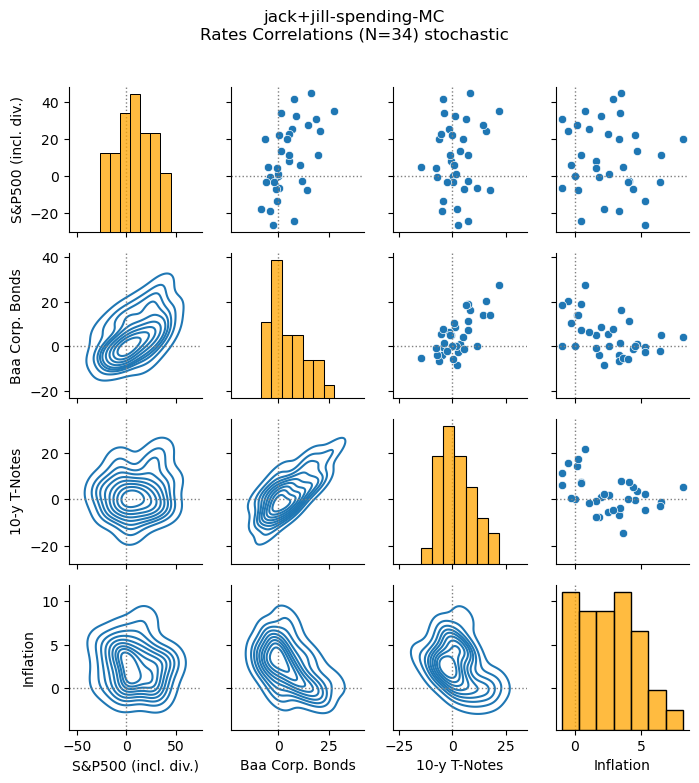

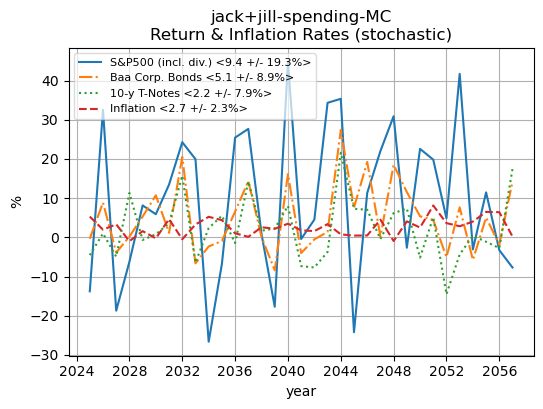

In [9]:
# Display a single instance resulting from this choice.
plan.showRatesCorrelations(shareRange=False)
plan.showRates()

In [10]:
plan.setHeirsTaxRate(33)
plan.setLongTermCapitalTaxRate(15)

Heirs tax rate on tax-deferred portion of estate set to 33%.
Long-term capital gain income tax set to 15%.


### Preparing the case to run
In order to run Monte Carlo simulations, one has first to set the rates to either *stochastic* or 'histochastic*. Then a call to 

    runMC(objective, options, N)
    
specifying the objective and options will generate a desired number of simulations and provide statistics. The last argument $N$ is the number of cases to consider. Unlike event-driven simulator, Owl performs an optimization for each case, which adds considerable computing costs. For this reason, the default behavior of Owl is to turn off Medicare calculations for these runs. It can be turned back on using 'withMedicare' to `True` in the options, but this will significantly increase (about 3X) the computing time while providing little more insight. These simulations are performed with no verbosity as many simulations are performed, but `runMC` accepts the `verbose=True` argument for debugging or curiosity purposes.

Running 500 cases takes about 5 min to complete. Be patient. At the end of the run, a histogram of the optimized values is displayed.
When running $N$ cases, the error on the estimate for the mean value being estimated decreases as $1/\sqrt{N - 1}$. Therefore, 500 cases are more than sufficient to obtain reliable and meaningful estimates of mean statistics.

Jack and Jill desire to leave a bequest of \\$500k (in today's \\$). 
We limit Roth conversions to a maximum of \\$150k for Jack and none for Jill.

What are these cases telling us?

In [11]:
options = {'maxRothConversion': 150, 'noRothConversions': 'Jill'}
# options['solver'] = 'MOSEK'

|--- progress ---|
100%
Success rate: 100.0% on 500 samples.
Optimized solutions all have null partial bequest in year 2051.
 maxSpending: Median (2024 $): $86,154
 maxSpending:   Mean (2024 $): $88,601
 maxSpending:           Range: $46,306 - $148,054
 maxSpending:  N zero solns: 0
CPU time used: 6m59.1s, Wall time: 5m32.1s.


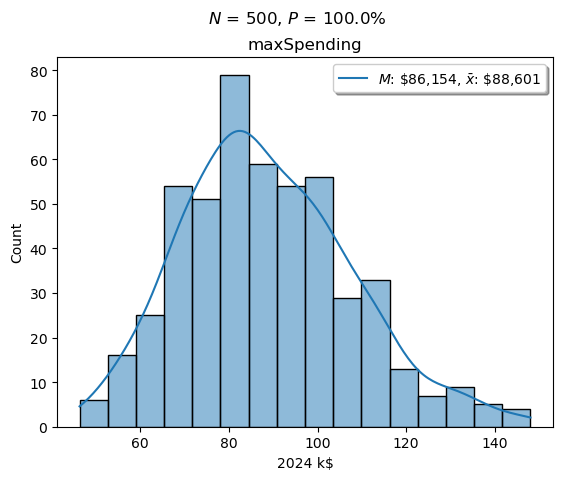

In [12]:
options['bequest'] = 500
plan.runMC('maxSpending', options, 500);

All cases are successful at leaving a \\$500k bequest, but the net spending required for achieving this constraint can lead to small values in some scenarios. However, the median value for the net spending is about \\$88k, very close to the \\$90k desired by Jack and Jill. Recall that we are using a more conservative return of 8%, with a volatility of 17% for the S&P 500. It is therefore natural that the number we find here is slightly lower than what the historical return of the market has been able to predict. Some of these scenarios will provide more than the median (\$M\$), but some others will require a net spending of about \\$50k. All these scenarios make a probability of 100\% for leaving a \\$500k bequest as requested. The mean value is indicated by $\bar{x}$.

A more practical example is to look at the maximum bequest left under the constraint of a fixed net spending.

|--- progress ---|
100%
Success rate: 82.8% on 500 samples.
Optimized solutions all have null partial bequest in year 2051.
partial 2051: Median (2024 $): $1,110,726
partial 2051:   Mean (2024 $): $1,582,087
partial 2051:           Range: $3,692 - $15,703,939
partial 2051:  N zero solns: 0
CPU time used: 4m30.0s, Wall time: 3m21.9s.


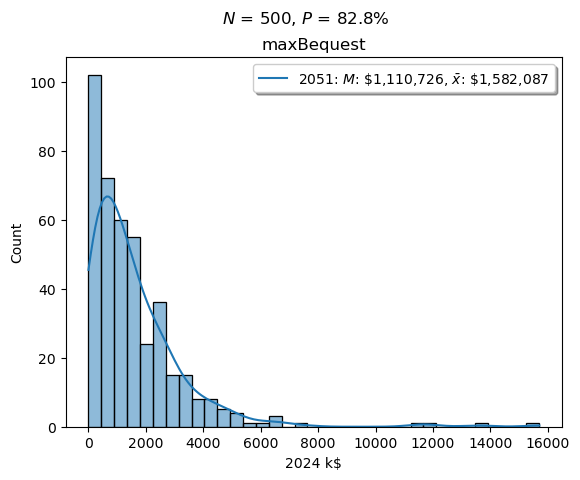

In [13]:
options['netSpending'] = 90
plan.runMC('maxBequest', options, 500);

In this case, a relatively large percentage of scenarios are successful in providing the desired \\$90k net spending amount over the duration of the plan. The median bequest left at the end of the plan is close to \\$1 M, twice what Jack and Jill are intending to leave. This might first suggest that the amount of \\$90k might be too conservative on average. The success rate is 85%, which is relatively good, especially considering the fact that Jack and Jill are always able to re-adjust their net spending plan as other forecast estimates are performed in the future.

### Running cases over a historical range or years
We can also run cases using the historical data over a range of years and compile the outcomes in a histogram. For this purpose, there is no need to pre-select specific rates using the `setRates()` method as the choice of *historical* rates is implicit. Only the year range is required.

Let's look at a specific example. For optimizing the net spending amount, we specify *maxSpending* in the following call to optimize the plan over the 63 years following 1928:

|--- progress ---|
100%
Success rate: 100.0% on 63 samples.
Optimized solutions all have null partial bequest in year 2051.
 maxSpending: Median (2024 $): $103,863
 maxSpending:   Mean (2024 $): $104,577
 maxSpending:           Range: $80,037 - $146,555
 maxSpending:  N zero solns: 0
CPU time used: 1m39.6s, Wall time: 1m12.7s.


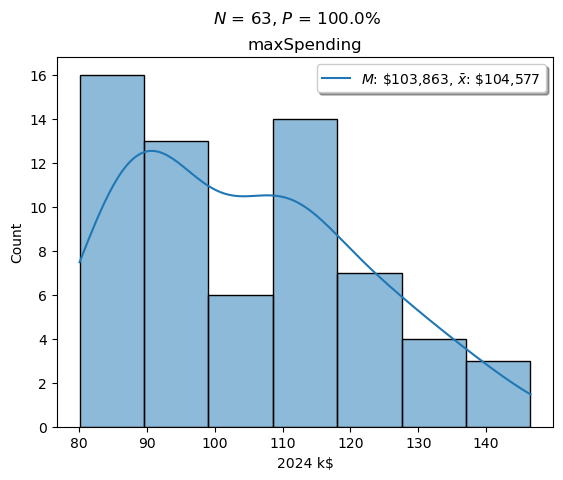

In [14]:
plan.runHistoricalRange('maxSpending', options, 1928, 1990);

When considering more historical data than a single year, we find a slightly larger net spending value than the one dictated from when only looking at the year 1969. This is not surprising as 1969 was not a good year to retire due to the high inflation rates that prevailed during the following decade. 

Let's now consider the case for *maxBequest* under a desired net spending.

|--- progress ---|
100%
Success rate: 100.0% on 63 samples.
Optimized solutions all have null partial bequest in year 2051.
partial 2051: Median (2024 $): $2,082,174
partial 2051:   Mean (2024 $): $2,884,808
partial 2051:           Range: $176,429 - $9,134,573
partial 2051:  N zero solns: 0
CPU time used: 1m10.9s, Wall time: 0m51.6s.


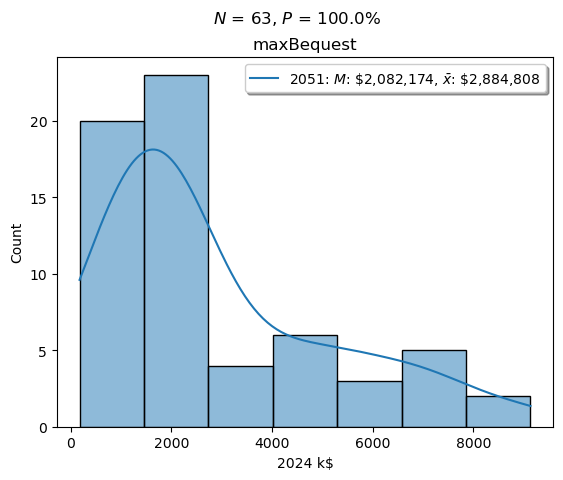

In [15]:
plan.runHistoricalRange('maxBequest', options, 1928, 1990);

The resulting success rate when considering all historical data is 100%. This is also not surprising as the original estimates for the net spending and the bequest were derived from running a case in 1969, the second next worst year of historical sequences of returns. 